**Base line**

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import precision_score, recall_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn import preprocessing
import glob as gb
import numpy as np
import pandas as pd
import os
import warnings
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import plotly.express as px
import seaborn as sns

from PIL import Image
from tqdm import tqdm
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import random

import cv2
import imghdr
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

<ipython-input-1-06aa3af253e1>:30: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


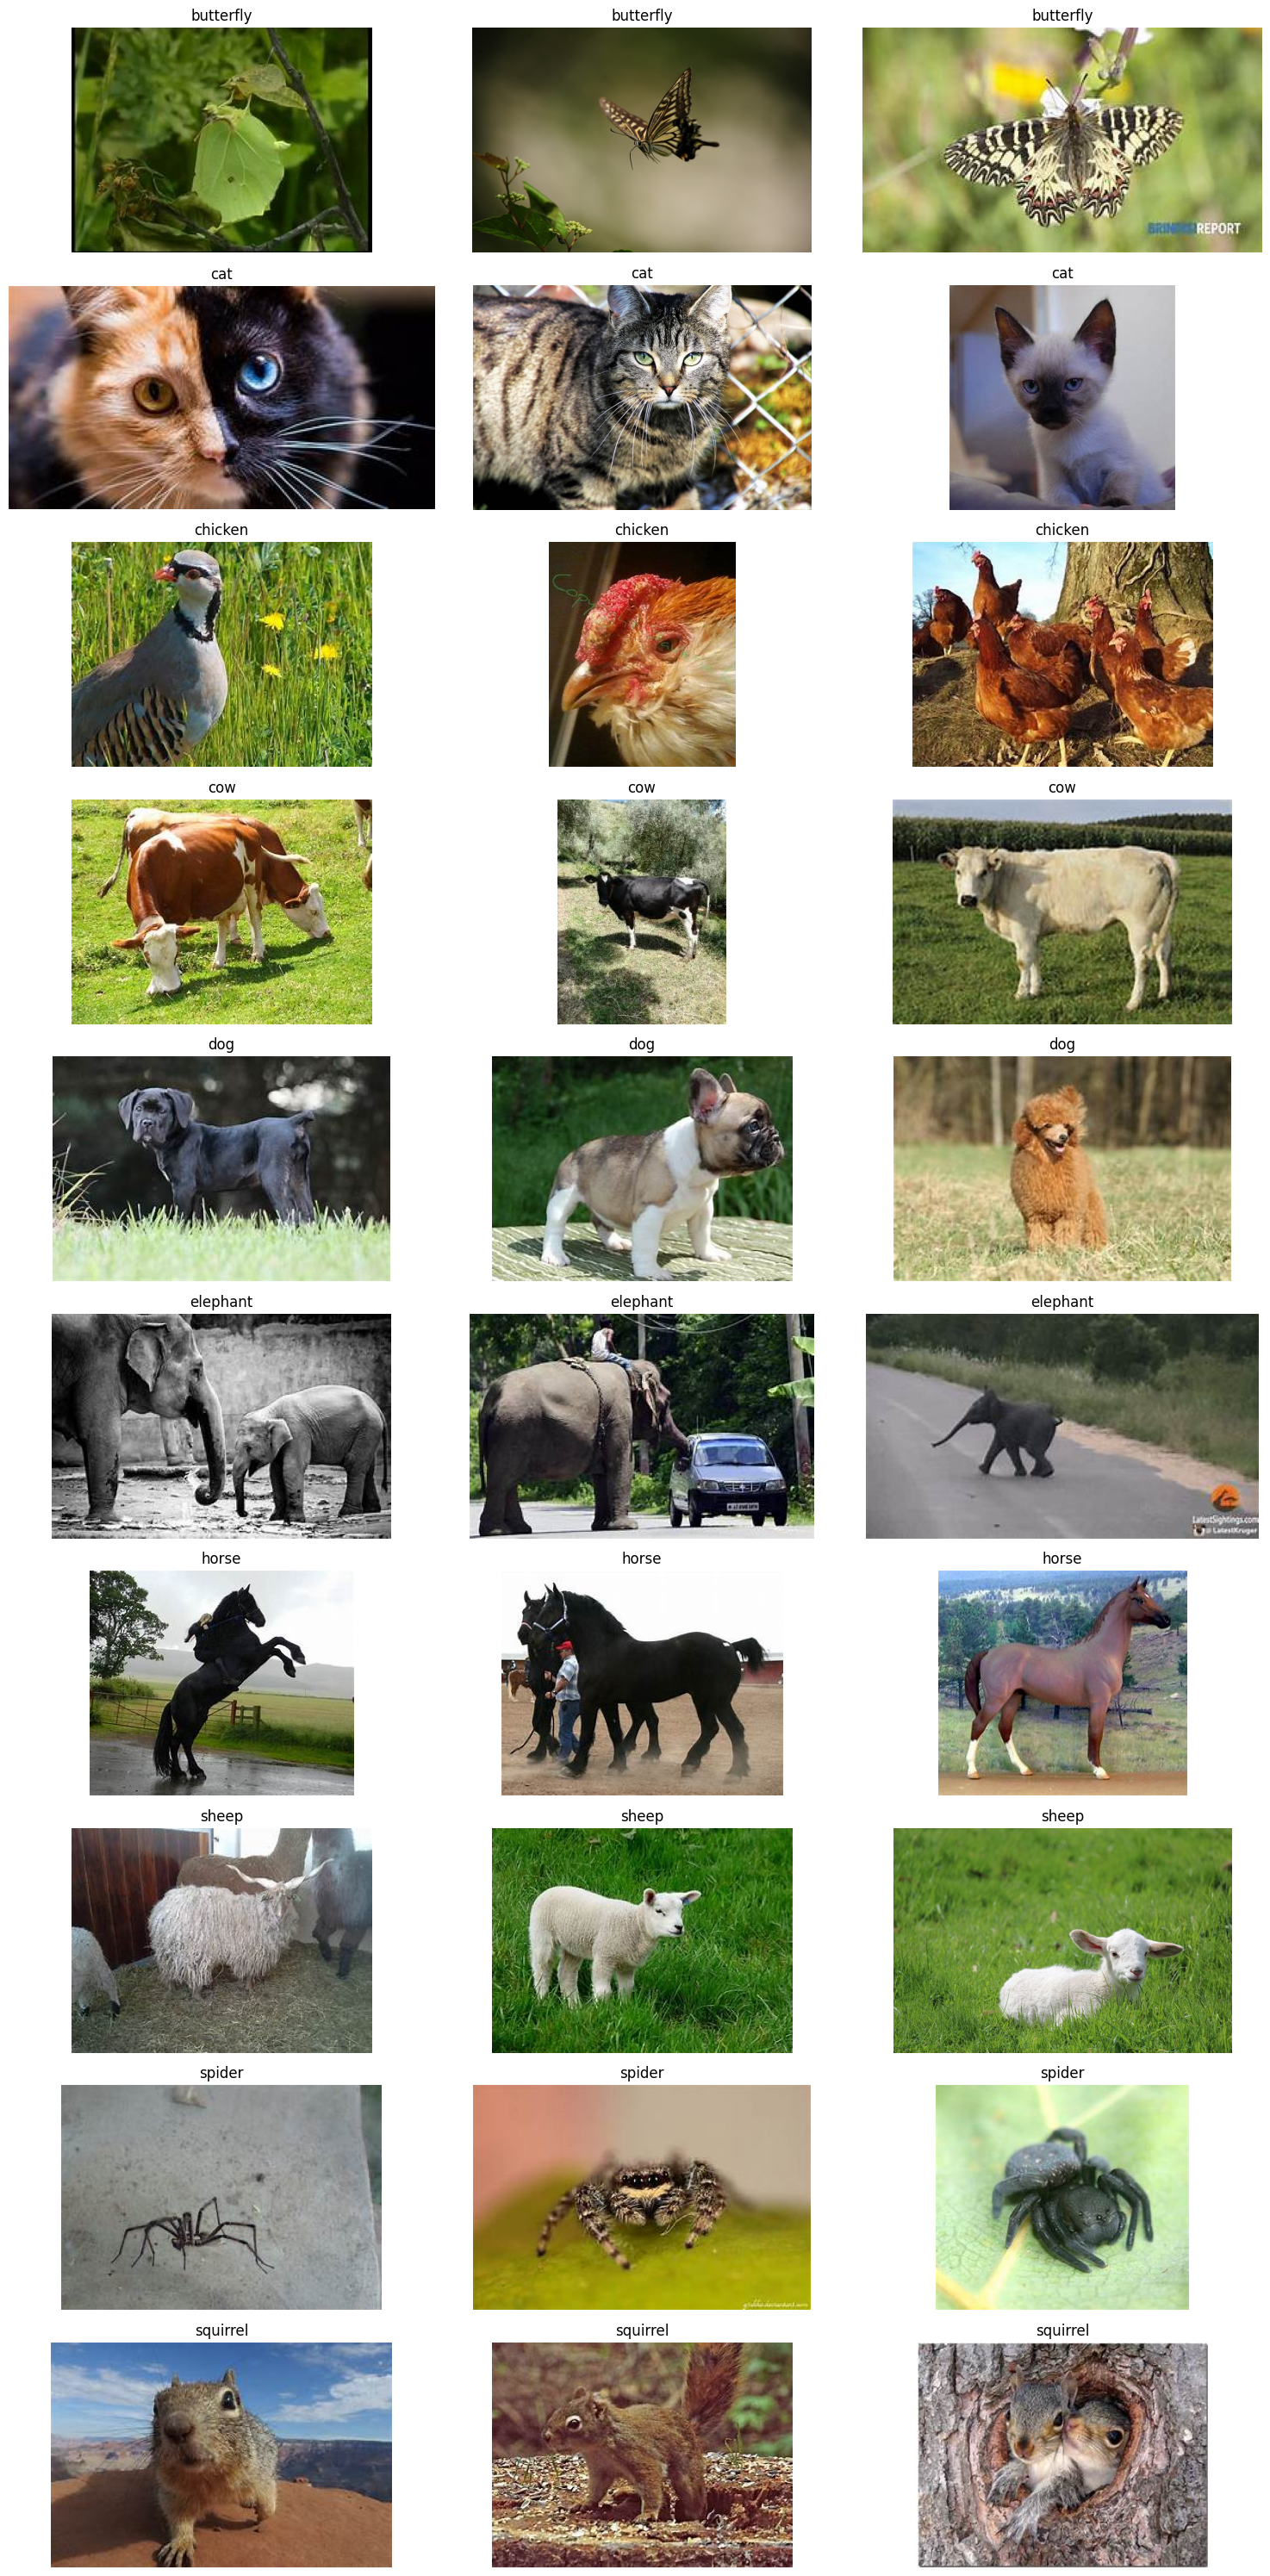

In [3]:
import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Path to the directory containing the images
base_directory = '/content/drive/MyDrive/animals10'

# Categories
categories = ['butterfly', 'cat', 'chicken', 'cow', 'dog', 'elephant', 'horse', 'sheep', 'spider', 'squirrel']

# Display three random images for each category
fig, axs = plt.subplots(len(categories), 3, figsize=(15, len(categories) * 3))

for i, category in enumerate(categories):
    category_directory = os.path.join(base_directory, category)
    files = os.listdir(category_directory)
    image_files = [file for file in files if file.endswith(('png', 'jpg', 'jpeg'))]
    random_images = random.sample(image_files, 3)

    for j, image_file in enumerate(random_images):
        image_path = os.path.join(category_directory, image_file)
        image = mpimg.imread(image_path)
        axs[i, j].imshow(image)
        axs[i, j].axis('off')
        axs[i, j].set_title(category)

plt.tight_layout()
plt.show()

In [4]:
# create test and train files
train_dir = '/content/drive/MyDrive/animals10_split/train'
test_dir = '/content/drive/MyDrive/animals10_split/test'

# show catagories
print("Categories:", categories)

Categories: ['butterfly', 'cat', 'chicken', 'cow', 'dog', 'elephant', 'horse', 'sheep', 'spider', 'squirrel']


In [5]:
train_dir = '/content/drive/MyDrive/animals10_split/train'
for i, category in enumerate(categories):
    category_directory = os.path.join(base_directory, category)
    files = os.listdir(category_directory)
    image_files = [file for file in files if file.endswith(('png', 'jpg', 'jpeg'))]
    print(f"for Training files is {category} is number of items is === {len(image_files)}")

for Training files is butterfly is number of items is === 2132
for Training files is cat is number of items is === 1668
for Training files is chicken is number of items is === 3098
for Training files is cow is number of items is === 1866
for Training files is dog is number of items is === 4863
for Training files is elephant is number of items is === 1446
for Training files is horse is number of items is === 2623
for Training files is sheep is number of items is === 1820
for Training files is spider is number of items is === 4821
for Training files is squirrel is number of items is === 1862


In [6]:
test_dir = '/content/drive/MyDrive/animals10_split/test'
for i, category in enumerate(categories):
    category_directory = os.path.join(test_dir, category)
    files = os.listdir(category_directory)
    image_files = [file for file in files if file.endswith(('png', 'jpg', 'jpeg'))]
    print(f"for Testing files is {category} is number of items is === {len(image_files)}")

for Testing files is butterfly is number of items is === 427
for Testing files is cat is number of items is === 334
for Testing files is chicken is number of items is === 620
for Testing files is cow is number of items is === 374
for Testing files is dog is number of items is === 973
for Testing files is elephant is number of items is === 290
for Testing files is horse is number of items is === 525
for Testing files is sheep is number of items is === 364
for Testing files is spider is number of items is === 965
for Testing files is squirrel is number of items is === 373


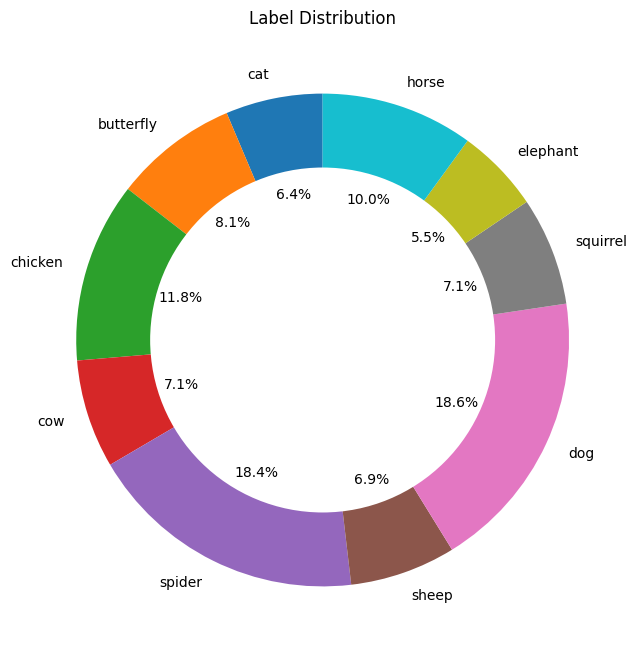

In [7]:
label_counts = {
    'cat': 1668,
    'butterfly': 2132,
    'chicken': 3098,
    'cow': 1866,
    'spider': 4821,
    'sheep': 1820,
    'dog': 4863,
    'squirrel': 1862,
    'elephant': 1446,
    'horse': 2623
}

labels = list(label_counts.keys())
sizes = list(label_counts.values())

# Plotting the pie chart
plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)

# Draw a circle at the center to make it a donut chart
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.title('Label Distribution')
plt.show()

In [8]:
# Define the categories
categories = ['cat', 'butterfly', 'chicken', 'cow', 'spider', 'sheep', 'dog', 'squirrel', 'elephant', 'horse']

# Counters for correct predictions and total predictions
correct_predictions = 0
total_predictions = 0

# Iterate through subdirectories and test images
for category_folder in os.listdir(test_dir):
    category_path = os.path.join(test_dir, category_folder)

    # Check if the item is a directory
    if os.path.isdir(category_path):
        print(f"Category: {category_folder}")

        # Iterate through images in the category
        for image_name in os.listdir(category_path):
            image_path = os.path.join(category_path, image_name)
            predicted_category = random.choice(categories)



            # Update counters
            total_predictions += 1
            if predicted_category == category_folder:
                correct_predictions += 1

# Calculate accuracy
accuracy = correct_predictions / total_predictions if total_predictions > 0 else 0.0
print(f"Total Correct Predictions: {correct_predictions}")
print(f"Total Predictions: {total_predictions}")
print(f"Accuracy: {accuracy * 100:.2f}%")

Category: butterfly
Category: cat
Category: chicken
Category: cow
Category: dog
Category: elephant
Category: horse
Category: sheep
Category: spider
Category: squirrel
Total Correct Predictions: 519
Total Predictions: 5245
Accuracy: 9.90%


**Simple softmax regression model**


In [9]:
# Load the image data and labels
X = []
y = []

for i, category in enumerate(categories):
    category_directory = os.path.join(base_directory, category)
    files = os.listdir(category_directory)
    image_files = [file for file in files if file.endswith(('png', 'jpg', 'jpeg'))]

    for image_file in image_files:
        image_path = os.path.join(category_directory, image_file)
        image = cv2.imread(image_path)
        image = cv2.resize(image, (64, 64))
        X.append(image.flatten())
        y.append(i)

X = np.array(X)
y = np.array(y)

In [10]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a logistic regression model
model = make_pipeline(StandardScaler(), LogisticRegression(max_iter=2000, random_state=42))

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)


print("Baseline Model Performance:")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")

# Display classification report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=categories))

Baseline Model Performance:
Accuracy: 0.27
Precision: 0.27
Recall: 0.27
Mean Squared Error (MSE): 11.69
Mean Absolute Error (MAE): 2.54
Classification Report:
              precision    recall  f1-score   support

         cat       0.09      0.11      0.10       320
   butterfly       0.26      0.22      0.24       458
     chicken       0.25      0.24      0.25       625
         cow       0.29      0.31      0.30       349
      spider       0.37      0.37      0.37       992
       sheep       0.24      0.22      0.23       382
         dog       0.29      0.29      0.29       950
    squirrel       0.18      0.20      0.19       358
    elephant       0.18      0.17      0.17       309
       horse       0.29      0.31      0.30       497

    accuracy                           0.27      5240
   macro avg       0.24      0.24      0.24      5240
weighted avg       0.27      0.27      0.27      5240



<Figure size 600x300 with 0 Axes>

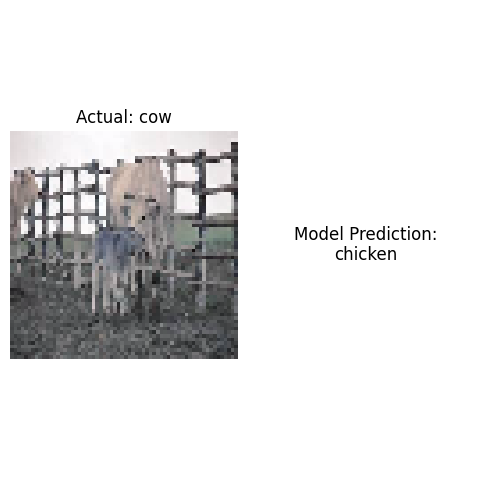

<Figure size 600x300 with 0 Axes>

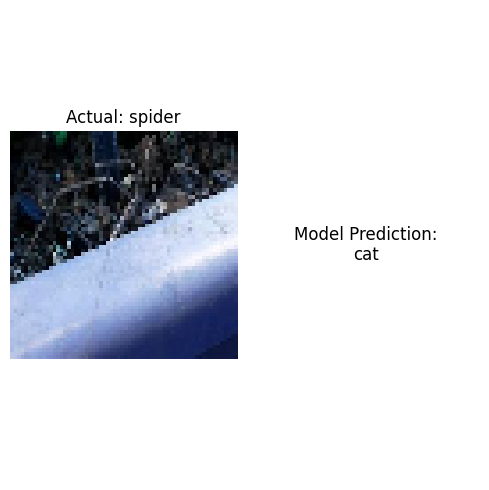

<Figure size 600x300 with 0 Axes>

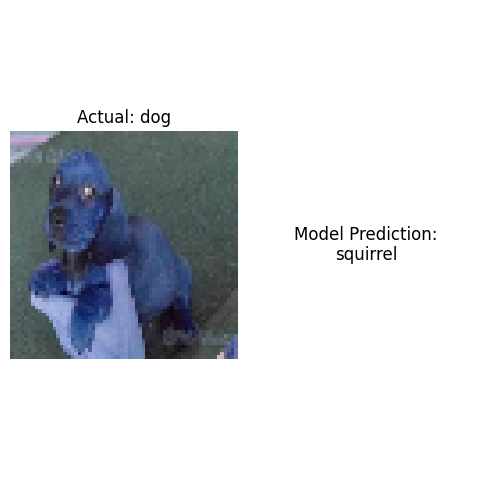

<Figure size 600x300 with 0 Axes>

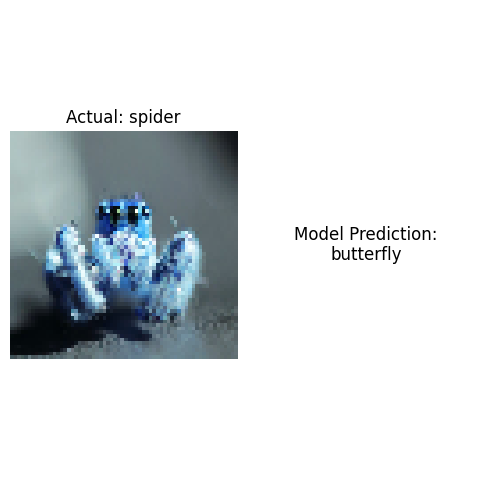

<Figure size 600x300 with 0 Axes>

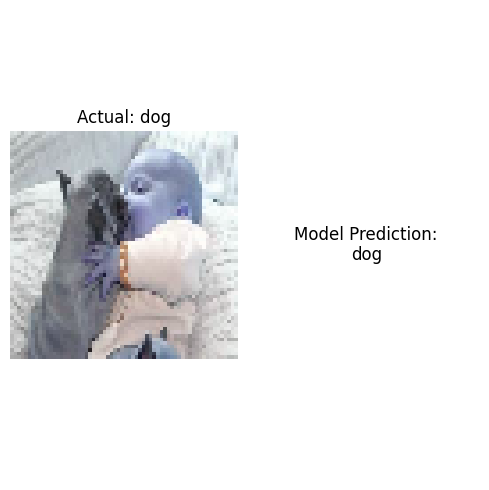

<Figure size 600x300 with 0 Axes>

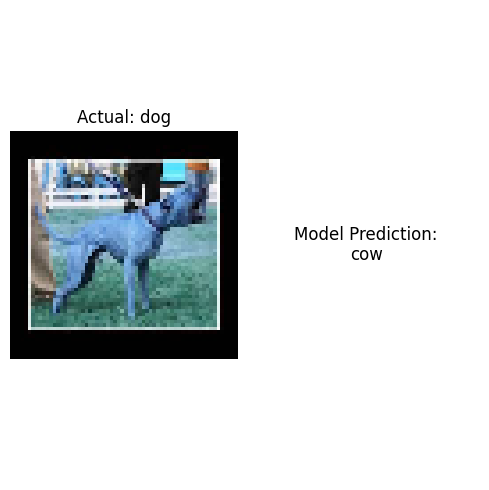

<Figure size 600x300 with 0 Axes>

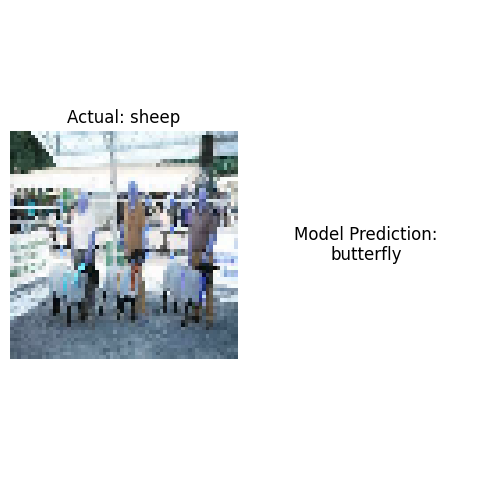

<Figure size 600x300 with 0 Axes>

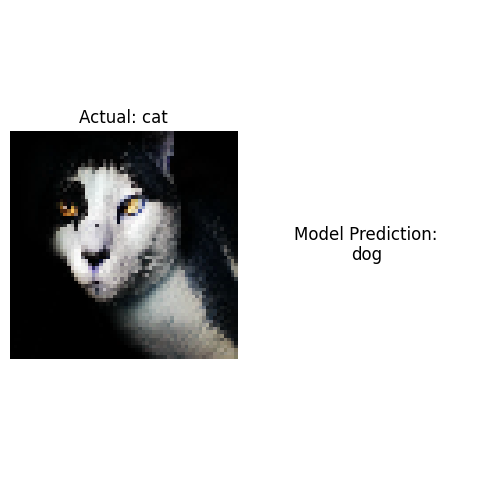

<Figure size 600x300 with 0 Axes>

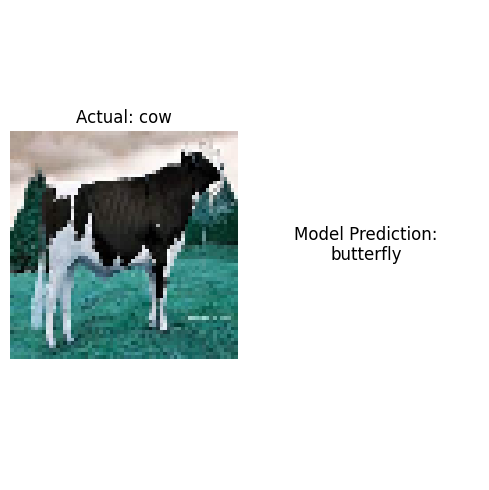

<Figure size 600x300 with 0 Axes>

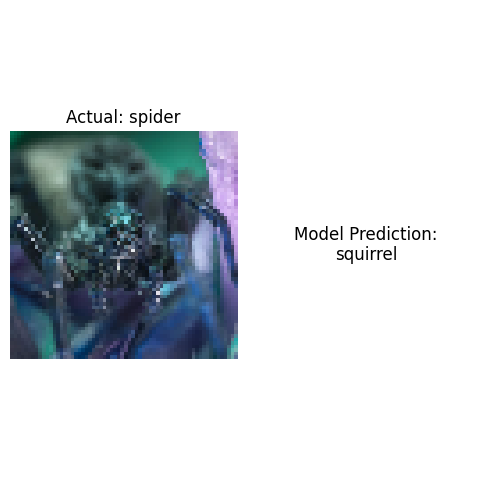

In [11]:
def visualize_predictions(X_test, y_true, y_pred, class_names):
    # Take the first 10 samples
    sample_indices = range(10)

    X_test = X_test.reshape(-1, 64, 64, 3)

    for i, index in enumerate(sample_indices):
        plt.figure(figsize=(6, 3))

       # Create a figure with two subplots side by side
        fig, axs = plt.subplots(1, 2, figsize=(5, 5))

        # Display the original image
        axs[0].imshow(X_test[index])
        true_label = class_names[(y_true[index])]
        axs[0].set_title(f"Actual: {true_label}", fontsize=12)
        axs[0].axis('off')

        # Display the model's prediction, combining textual and visual elements
        predicted_class = (y_pred[index])
        predicted_label = categories[predicted_class]

        axs[1].text(0.5, 0.5, f"Model Prediction:\n{predicted_label}", ha='center', va='center', fontsize=12)
        axs[1].axis('off')

        # Adjust layout and display the combined visualization
        plt.tight_layout()
        plt.show()

# Call the function after defining it and ensuring variables are in scope
visualize_predictions(X_test, y_test, y_pred, categories)

In [12]:
from tensorflow import keras

# Define the model architecture
MLPmodel = keras.Sequential([
  keras.layers.Flatten(input_shape=(150, 150, 3)),
  keras.layers.Dense(128, activation='relu'),
  keras.layers.Dense(64, activation='relu'),
  keras.layers.Dense(10, activation='softmax')
])

# Compile the model (specifying optimizer, loss function, and metrics)
MLPmodel.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [13]:
MLPmodel.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 67500)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       8,640,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,648,709 (32.99 MB)

 Trainable params: 8,648,709 (32.99 MB)

 Non-trainable params: 0 (0.00 B)

**logistic regression with grid search- find the best hyperparameters.**



In [14]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
len(X_train)/5

4191.8

In [15]:
from sklearn.model_selection import GridSearchCV

# Define the hyperparameter grid
param_grid = {
    'logisticregression__C': [0.001, 0.01, 0.1, 1, 10],
    'logisticregression__solver': ['lbfgs', 'newton-cg', 'liblinear']
}

# Create the pipeline with LogisticRegression
pipeline = make_pipeline(StandardScaler(), LogisticRegression(max_iter=2000, random_state=42))

# Create the GridSearchCV object
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

In [16]:
def batch_train_predict(X, y, batch_size, model_class=LogisticRegression, **model_kwargs):
  """
  Trains a model on the data in batches and predicts on unseen data.

  Args:
      X: Training features.
      y: Training targets.
      batch_size: Size of data batches.
      model_class: The model class to use (e.g., LogisticRegression).
      model_kwargs: Keyword arguments to pass to the model constructor.

  Returns:
      y_pred: Predictions on unseen data.
  """
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
  scaler = StandardScaler()
  X_train_scaled = []

  for i in range(0, len(X_train), batch_size):
    batch_X = X_train[i:i+batch_size]
    batch_X_scaled = scaler.fit_transform(batch_X)
    X_train_scaled.append(batch_X_scaled)

  # Combine scaled batches into a single array
  X_train_scaled = np.concatenate(X_train_scaled, axis=0)

  model = model_class(**model_kwargs)
  model.fit(X_train_scaled, y_train)

  X_test_scaled = scaler.transform(X_test)
  y_pred = model.predict(X_test_scaled)
  return y_pred

# Call the function with your data, batch size, and model details
batch_size = 1860
y_pred = batch_train_predict(X, y, batch_size, model_class=LogisticRegression, max_iter=2000, random_state=42)

# Evaluate the model's performance
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')

print("Logistic Regression Performance:")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")

Logistic Regression Performance:
Accuracy: 0.27
Precision: 0.27
Recall: 0.27
